In [1]:
import sys
sys.path.append("../")
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

from dataset.dataset import Dataset
from src.model import FEBM
from src.trainer import Trainer
from src.kernel import StringToKernel
from src.cd import CD

%load_ext autoreload
%autoreload 2

## Dataset

We recommend inheriting from `Dataset` in `src/dataset.py`. For example, in the toy example of `Quadratic`. We define the object as

In [2]:
class Polynomial(Dataset):
    def __init__(self,
                 n_samples=400,
                 train_portion=0.5,
                 n_eval=30,
                 seed=1):
        n_train = int(n_samples * train_portion)
        x = torch.linspace(-5, 5, steps=n_eval).unsqueeze(-1)
        x = x.repeat(n_samples, 1, 1)
        a = torch.bernoulli(0.5 * torch.ones(n_samples)).unsqueeze(-1).unsqueeze(-1)* 2 - 1.
        b = torch.randn(n_samples).unsqueeze(-1).unsqueeze(-1) * 1
        c = torch.randn(n_samples).unsqueeze(-1).unsqueeze(-1) * 10
        y = x ** 2 * a + x * b + c
        
        # Variables that we need to initialize.
        self.x = torch.linspace(-5, 5, steps=n_eval).unsqueeze(-1)
        self.train_dataset = torch.utils.data.TensorDataset(x[:n_train],
                                                            y[:n_train])
        self.eval_dataset = torch.utils.data.TensorDataset(x[n_train:],
                                                            y[n_train:])
        self.train_dataset.x = self.x
        self.eval_dataset.x = self.x
        self._y_dim = 1
dataset = Polynomial()

## Model

The model described in the paper is implemented as a class named `FEBM` (located in `src/model.py`) and instantiated as follows

In [3]:
n_weights = 30
kernel = StringToKernel("m")
model = FEBM(n_weights,
             dataset.x,
             dataset.y_dim,
             kernel,
             sigma=0.1,
             latent_dim=100)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jenninglim/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 66.0 K
1 | act1 | ReLU   | 0     
2 | fc2  | Linear | 262 K 
3 | act2 | ReLU   | 0     
4 | fc3  | Linear | 15.4 K
--------------------------------
344 K     Trainable params
0         Non-trainable params
344 K     Total params
1.376     Total estimated model params size (MB)
/home/jenninglim/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing 

Training: 0it [00:00, ?it/s]

2023-02-21 01:09:53.606296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 01:09:54.220779: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-21 01:09:55.455017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-21 01:09:55.455182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Training

In [4]:
n_epochs = 500
loss = CD(model)
opt = torch.optim.Adam(model.parameters(), 1e-3)
scheduler = ReduceLROnPlateau(opt,
                              'min',
                              patience=3,
                              factor=0.8,
                              min_lr=1e-5)
trainer = Trainer(model,
                  opt,
                  dataset.train_dataset,
                  loss,
                  scheduler=scheduler)

trainer.train(n_epochs=n_epochs, patience=30)

  0%|          | 0/500 [00:00<?, ?it/s]

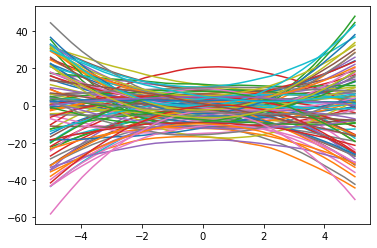

In [5]:
n_functions = 100
y_out = trainer.best_model.sample_function(dataset.x.unsqueeze(0), n_functions=n_functions, steps=300, clip_norm=True).detach()
for i in range(n_functions):
    plt.plot(dataset.x, y_out[i, 0])